<a href="https://colab.research.google.com/github/vicmcl/malaria-detection/blob/main/malaria-detection/notebook_malaria_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Malaria Detection**

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
!git clone https://github.com/vicmcl/malaria-detection.git

Cloning into 'malaria-detection'...
remote: Enumerating objects: 133, done.
remote: Counting objects: 100% (133/133), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 133 (delta 70), reused 89 (delta 46), pack-reused 0
Receiving objects: 100% (133/133), 685.10 KiB | 2.67 MiB/s, done.
Resolving deltas: 100% (70/70), done.


In [5]:
import os
os.chdir("malaria-detection")

In [32]:
!git pull origin main

remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 5 (delta 4), reused 5 (delta 4), pack-reused 0
Unpacking objects: 100% (5/5), 413 bytes | 413.00 KiB/s, done.
From https://github.com/vicmcl/malaria-detection
 * branch            main       -> FETCH_HEAD
   6315e48..2cac532  main       -> origin/main
Updating 6315e48..2cac532
Fast-forward
 malaria-detection/utils/plots.py | 1 -
 1 file changed, 1 deletion(-)


## **Mount the Drive**

In [7]:
from google.colab import userdata

username = userdata.get('KAGGLE_USERNAME')
api_key = userdata.get('KAGGLE_KEY')

In [8]:
import os
import subprocess
import json

KAGGLE_CONFIG_DIR = os.path.join(os.path.expandvars('$HOME'), '.kaggle')
os.makedirs(KAGGLE_CONFIG_DIR, exist_ok = True)
api_dict = {"username":username, "key":api_key}

with open(f"{KAGGLE_CONFIG_DIR}/kaggle.json", "w", encoding='utf-8') as f:
    json.dump(api_dict, f)

cmd = f"chmod 600 {KAGGLE_CONFIG_DIR}/kaggle.json"
output = subprocess.check_output(cmd.split(" "))
output = output.decode(encoding='UTF-8')

print(output)

In [9]:
!python malaria-detection/utils/get_dataset.py

Dataset URL: https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria


In [19]:
from utils.checkpoint import checkpoint
from utils.plots import plot_images, plot_training, settings
from utils.prediction import prediction
from utils.preprocessing import preprocess_data

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import seaborn as sns

DATA_PATH = os.path.abspath("data/cell_images")
settings()

In [11]:
x_train, x_test, y_train, y_test = preprocess_data(DATA_PATH)

In [ ]:
print(x_train.shape)
print(x_test.shape)

(22046, 64, 64, 3)
(5512, 64, 64, 3)


#### **Countplots**

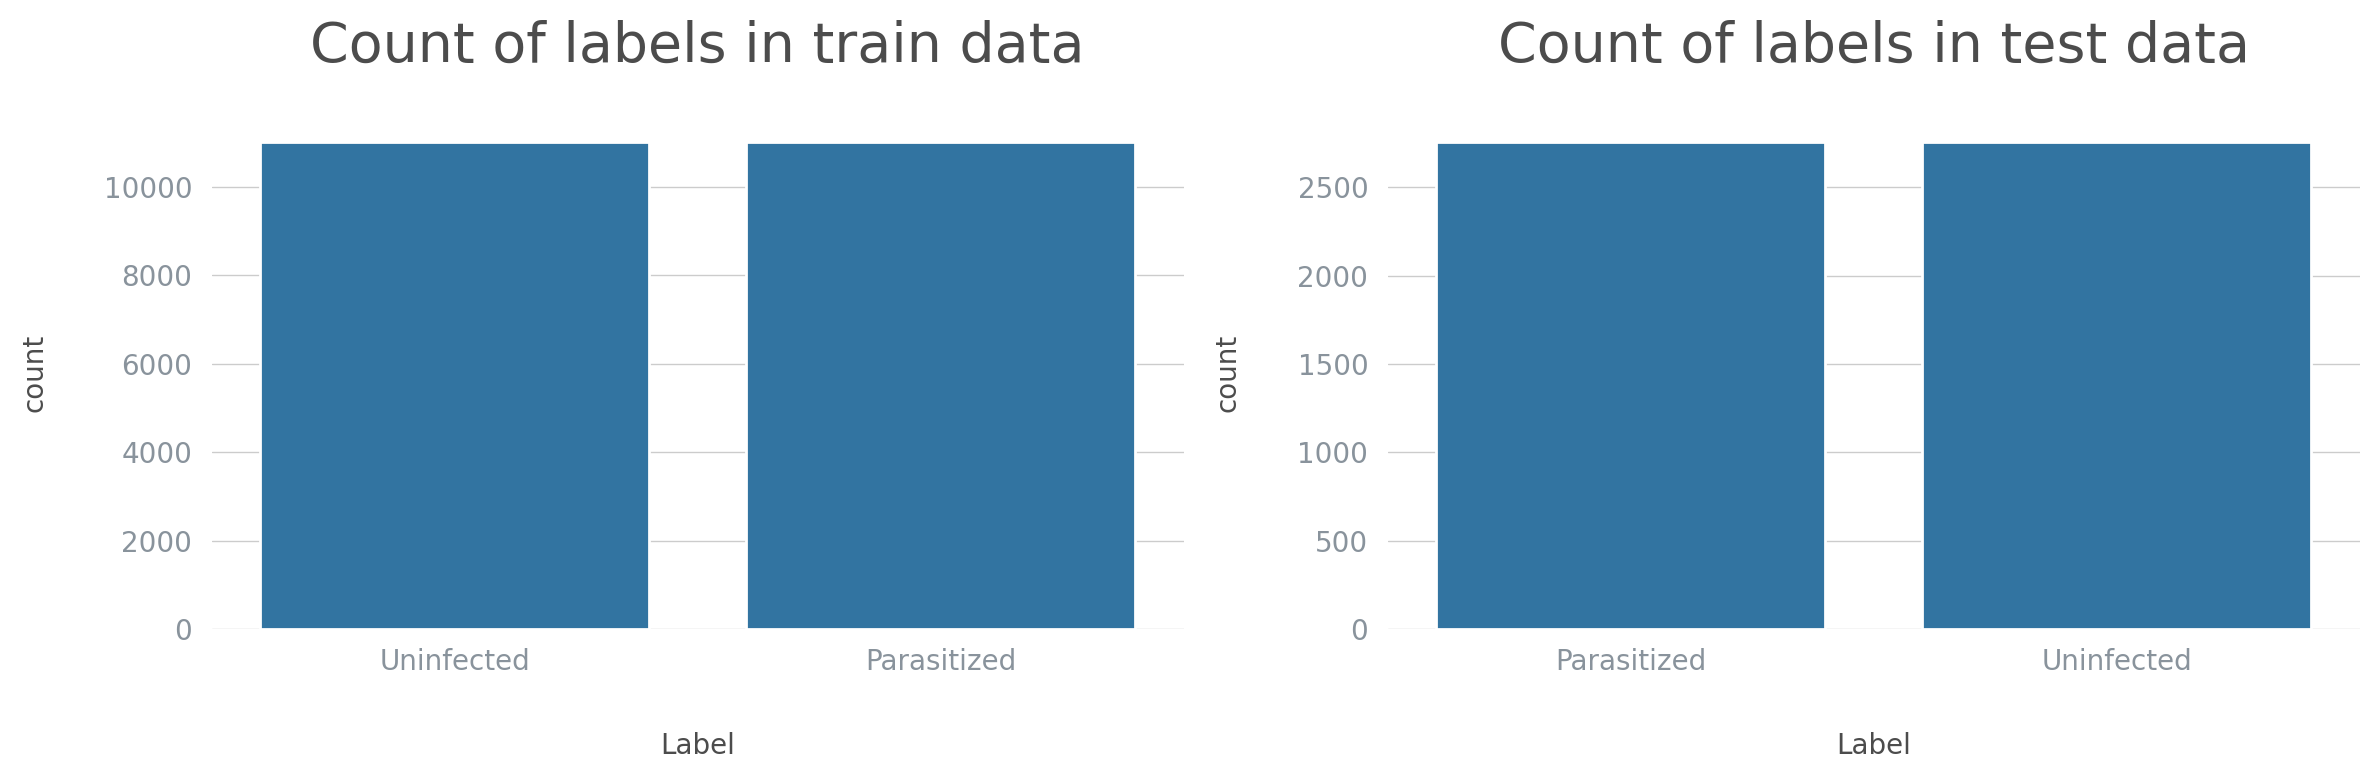

In [ ]:
fig = plt.figure(figsize = (12, 4))
labels = ["Uninfected", "Parasitized"]

# Create two dataframe to associate each image with its label
for i, data in enumerate([(x_train, y_train), (x_test, y_test)]):
    df = pd.DataFrame(
        zip(data[0], data[1]), columns = ["Image", "Label"]
    )
    fig.add_subplot(1, 2, i + 1)
    for j, lab in enumerate(labels):
        df["Label"] = df["Label"].replace(j, lab)

    # Plot the countplot of labels in df_train
    sns.countplot(data = df, x = "Label")

    title = "train" if i == 0 else "test"
    plt.gca().set_title(f"Count of labels in {title} data")

plt.tight_layout()
plt.show()

- The training dataset is well balanced with a 50/50 split between the images of parasitized and uninfected cells. Therefore, the models should be able to train on a similar number of images of parasitized and uninfected cells, which is likely to improve the results against new data.

#### **Visualization**

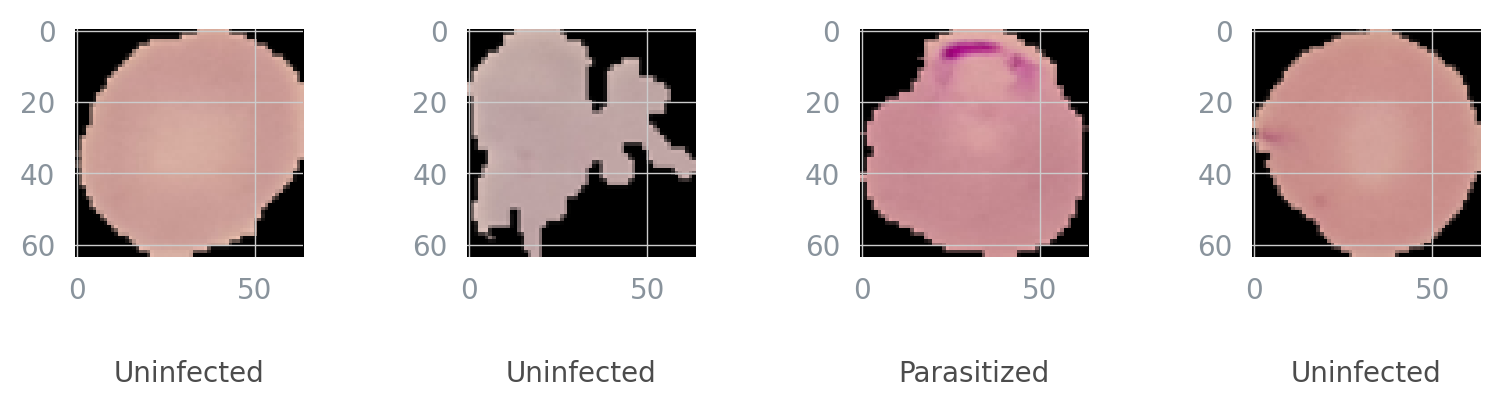

In [ ]:
plot_images(x_train, y_train, 4)

## **CNN**

In [57]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from tensorflow.math import confusion_matrix
from tensorflow.random import set_seed

from tensorflow.keras import backend, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    LeakyReLU,
    Dense,
    Flatten,
    Dropout,
    BatchNormalization,
)


####<b>One Hot Encoding the train and test labels</b>

In [13]:
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

#### **Plotting the confusion matrix**

In [35]:
def report_and_matrix(test, pred):
    # Print the classification report
    report = classification_report(test, pred)

    print(report)
    print("----------------------------------------------------------------------")
    print()

    # Plot the confusion matrix
    cm = confusion_matrix(test, pred)
    ax = sns.heatmap(
            cm,
            annot = True,
            linewidths = 0.4,
            fmt = "d",
            square = True,
         )

    ax.set(
        xlabel = 'Predicted Labels',
        ylabel = 'True Labels',
    )

    plt.show()

    # Return the report and the confusion matrix in a dictionary
    return {"report": report, "matrix": cm}

In [54]:
backend.clear_session()
np.random.seed(42)
random.seed(42)
set_seed(42)

#### **Building the model**

In [63]:
# Sequential model
model = Sequential(
    name = "Light_CNN",
    layers = [
        Conv2D(
            filters = 32,
            kernel_size = 2,
            padding = "same",
            activation = "relu",
            input_shape = (64, 64, 3),
        ),
        MaxPooling2D(pool_size = 2),
        Dropout(rate = 0.3),
        Conv2D(
            filters = 64,
            kernel_size = 2,
            padding = "same",
            activation = "relu",
        ),
        MaxPooling2D(pool_size = 2),
        Dropout(rate = 0.3),
        Flatten(),
        Dense(units = 128, activation = "relu"),
        Dropout(rate = 0.5),
        Dense(2, activation = 'softmax')
    ]
)

model.summary()
model.compile(
    loss="binary_crossentropy",
    optimizer = Adam(learning_rate = 0.0005),
    metrics = ["accuracy"]
)

history = model.fit(
    x_train,
    y_train_encoded,
    epochs = 100,
    callbacks = checkpoint("weights_light_cnn.keras", patience = 3),
    validation_split = 0.2,
    batch_size = 32,
    verbose = 1
)

Model: "Light_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        416       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        8256      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 64)        0 

#### **Plotting the train and the validation curves**

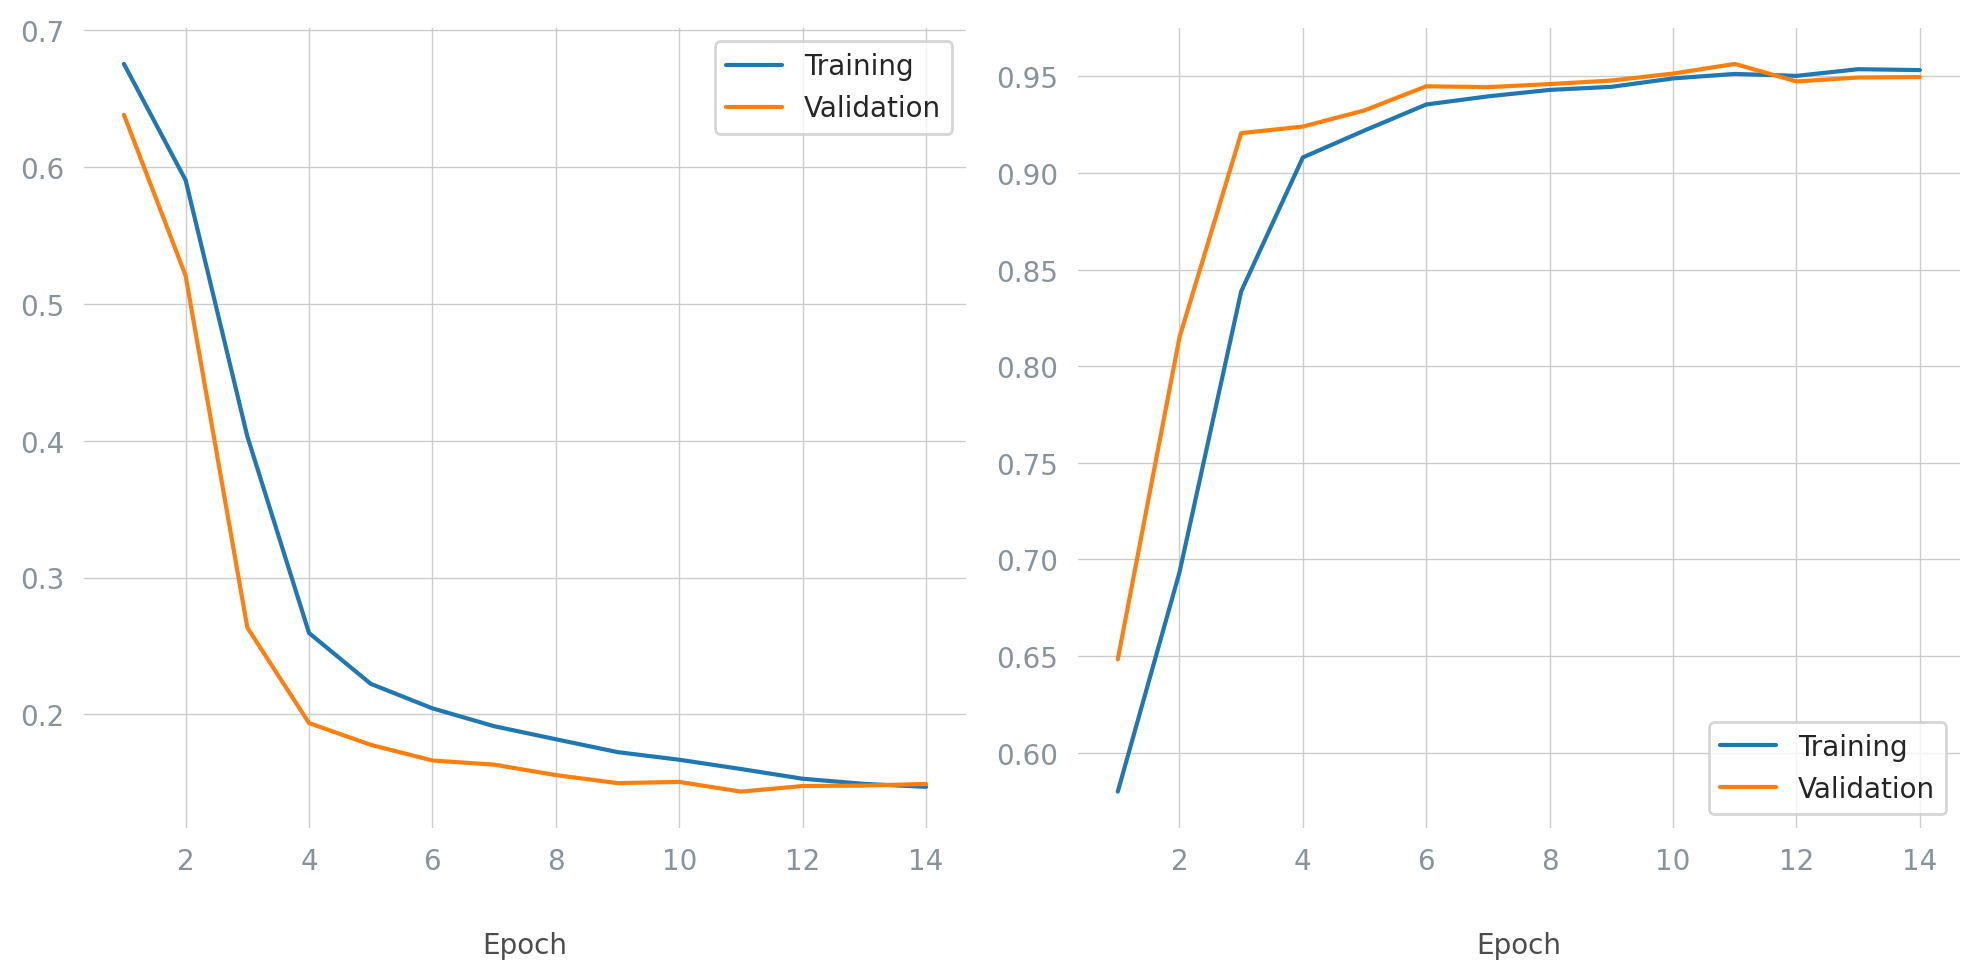

In [64]:
plot_training(history)

#### **Evaluating the model**

In [65]:
test_1, pred_1 = prediction(model, x_test, y_test_encoded)

173/173 [==============================] - 0s 2ms/step


#### **Plotting the confusion matrix**

              precision    recall  f1-score   support

           0       0.95      0.94      0.95      2756
           1       0.94      0.95      0.95      2756

    accuracy                           0.95      5512
   macro avg       0.95      0.95      0.95      5512
weighted avg       0.95      0.95      0.95      5512

----------------------------------------------------------------------



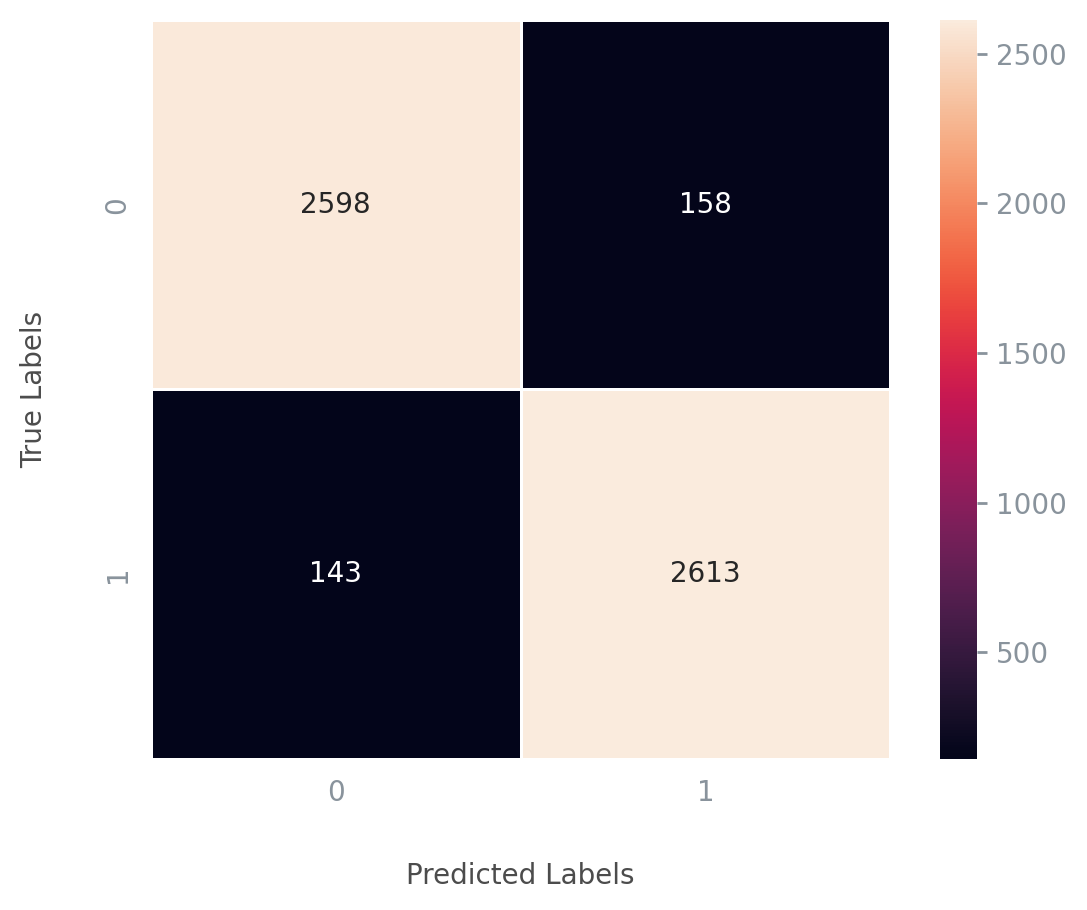

In [66]:
stat_1 = report_and_matrix(test_1, pred_1)

## **Data Augmentation**

In [67]:
model_aug = clone_model(model)
model_aug.compile(
    loss="binary_crossentropy",
    optimizer = Adam(learning_rate = 0.0005),
    metrics = ["accuracy"]
)

In [51]:
# Parameters to generate new images
train_generator = ImageDataGenerator(
    horizontal_flip=True, # Can flip the image upside down
    zoom_range=0.5,       # Can zoom in the image up to 2x
    rotation_range=30,     # Can rotate the image up to 30°
    validation_split = 0.2
)
val_generator = ImageDataGenerator(validation_split = 0.2)

# Create an iterator with new images
augmented_train_data = train_generator.flow(
    x = x_train,
    y = y_train_encoded,
    batch_size = 32,
    seed = 42,
    shuffle = True,
    subset = "training"
)

val_data = val_generator.flow(
    x = x_train,
    y = y_train_encoded,
    batch_size = 32,
    seed = 42,
    shuffle = True,
    subset = "validation"
)

In [68]:
history_augmented = model_aug.fit(
    augmented_train_data,
    epochs = 100,
    callbacks=checkpoint("weights_light_cnn_augmented.keras", patience = 3),
    validation_data = val_data,
    verbose = 1
)

Epoch 1/100
552/552 [==============================] - 20s 34ms/step - loss: 0.6643 - accuracy: 0.6007 - val_loss: 0.6428 - val_accuracy: 0.7285
Epoch 2/100
552/552 [==============================] - 19s 34ms/step - loss: 0.6062 - accuracy: 0.6974 - val_loss: 0.5399 - val_accuracy: 0.7877
Epoch 3/100
552/552 [==============================] - 19s 35ms/step - loss: 0.5019 - accuracy: 0.7942 - val_loss: 0.3530 - val_accuracy: 0.8982
Epoch 4/100
552/552 [==============================] - 19s 34ms/step - loss: 0.3636 - accuracy: 0.8649 - val_loss: 0.2277 - val_accuracy: 0.9238
Epoch 5/100
552/552 [==============================] - 19s 34ms/step - loss: 0.3091 - accuracy: 0.8819 - val_loss: 0.2124 - val_accuracy: 0.9322
Epoch 6/100
552/552 [==============================] - 19s 34ms/step - loss: 0.2920 - accuracy: 0.8988 - val_loss: 0.2093 - val_accuracy: 0.9399
Epoch 7/100
552/552 [==============================] - 19s 34ms/step - loss: 0.2836 - accuracy: 0.9036 - val_loss: 0.1960 - val_ac

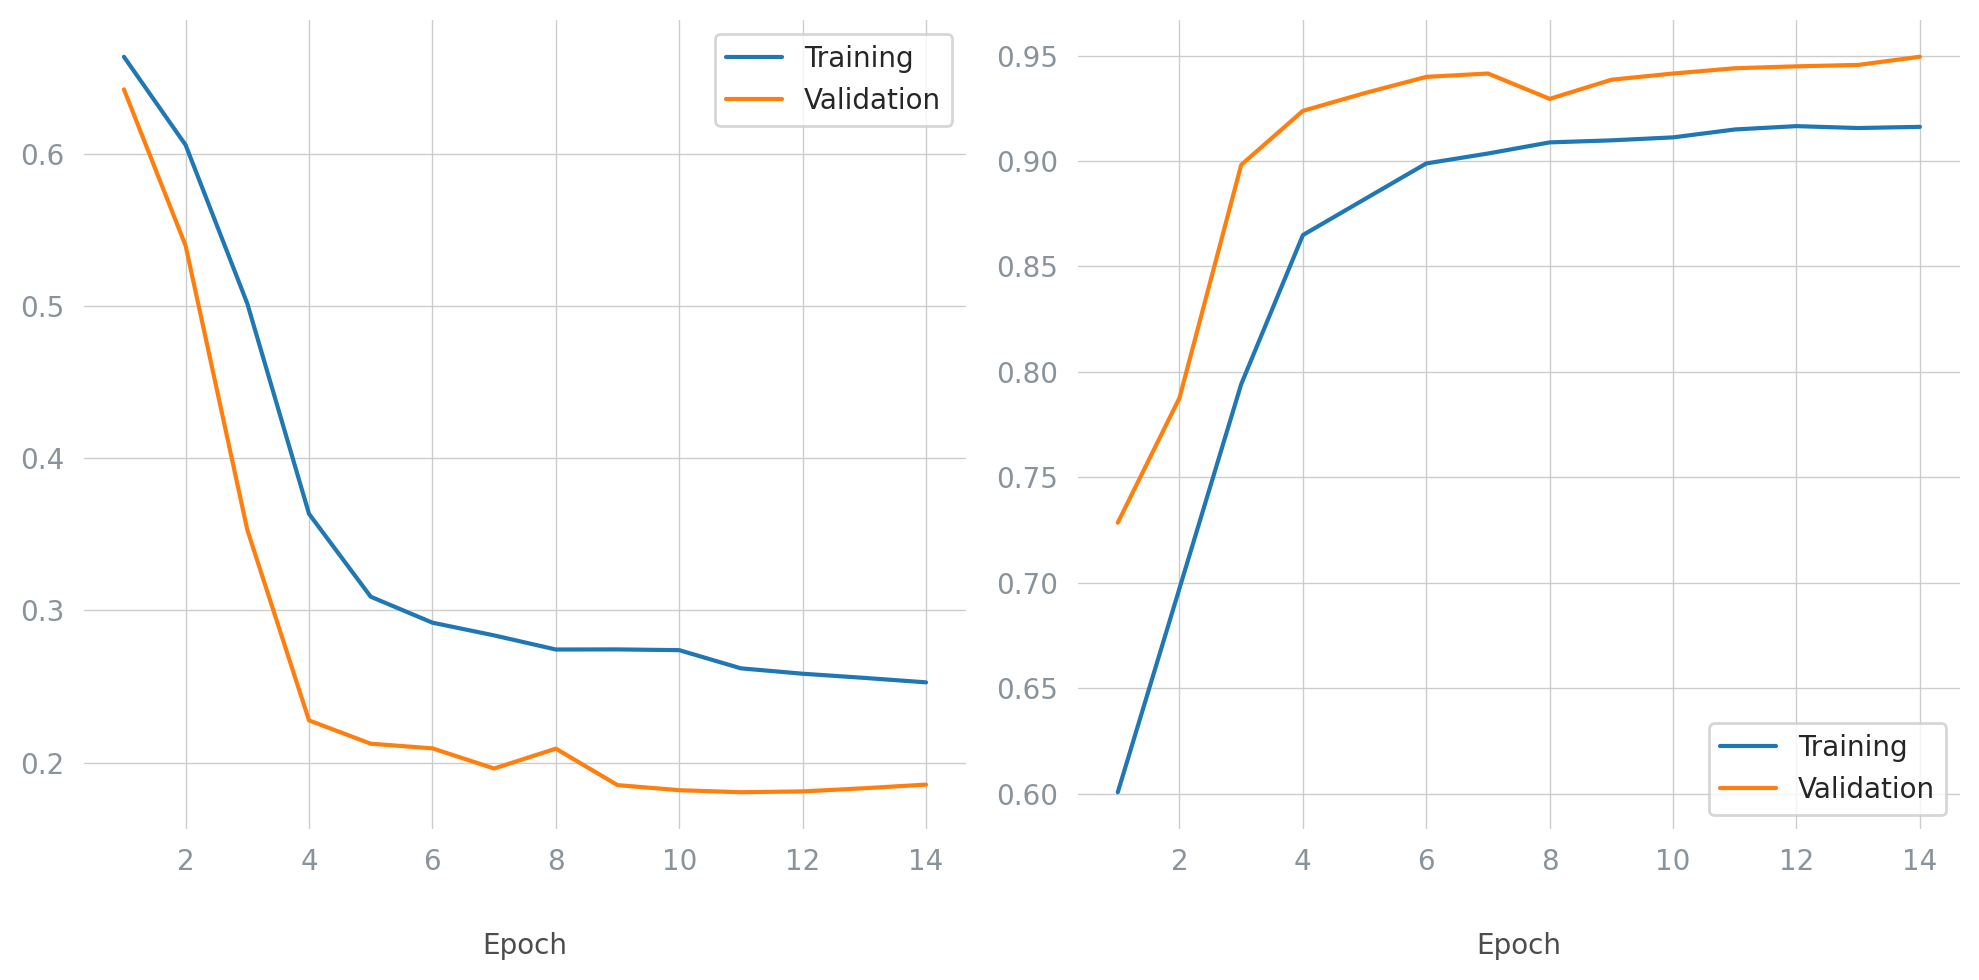

In [69]:
plot_training(history_augmented)

In [70]:
test_2, pred_2 = prediction(model_aug, x_test, y_test_encoded)

173/173 [==============================] - 0s 2ms/step


              precision    recall  f1-score   support

           0       0.94      0.96      0.95      2756
           1       0.96      0.94      0.95      2756

    accuracy                           0.95      5512
   macro avg       0.95      0.95      0.95      5512
weighted avg       0.95      0.95      0.95      5512

----------------------------------------------------------------------



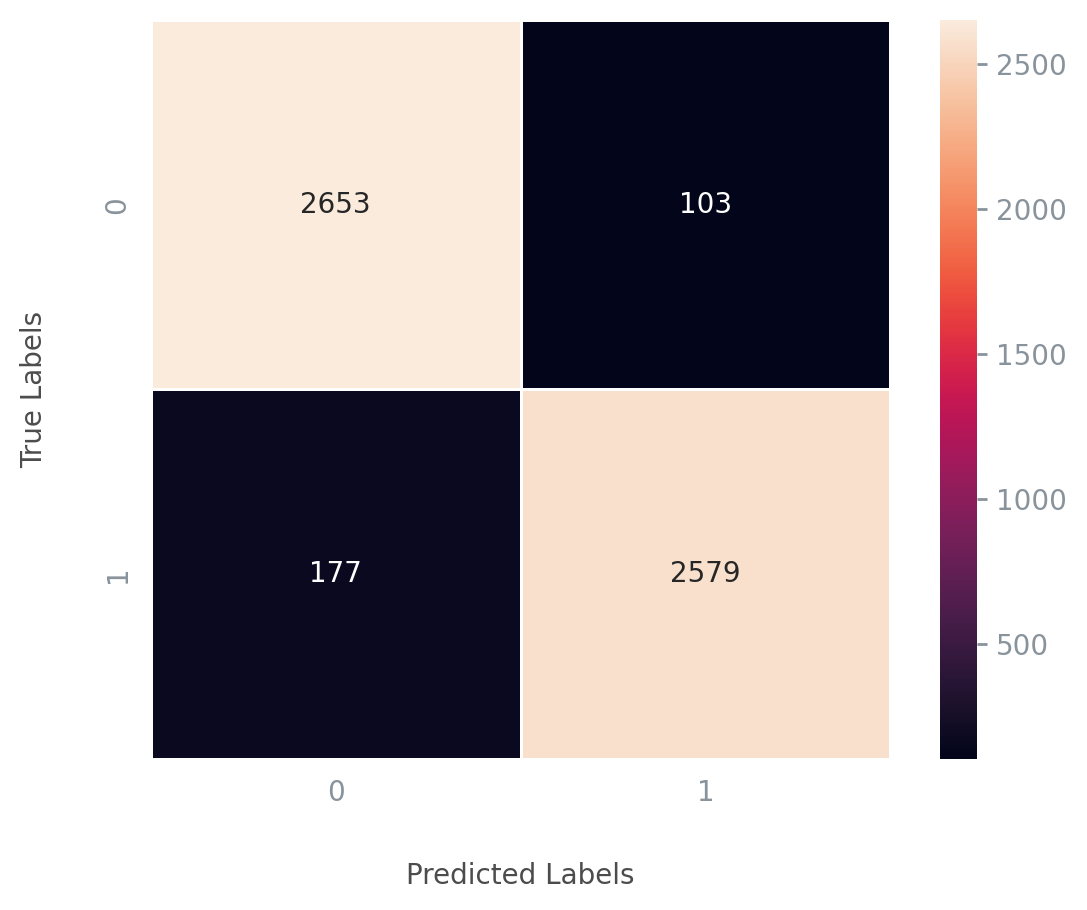

In [71]:
stat_5 = report_and_matrix(test_2, pred_2)